In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

In [31]:
from dataclasses import dataclass

@dataclass(frozen=True)
class DatasetConfig:
    SEED_VALUE:  int = 41
    CUT_PLANE:   str = "transversal"
    HEIGHT: int = 400
    WIDTH: int = 400
         
    DATA_ROOT_TARGET:  str = f'/home/jovyan/data/pre-processed-autopet-min-{CUT_PLANE}' 
    DATA_ROOT_TRAIN:  str = DATA_ROOT_TARGET + '/Train' 
    DATA_ROOT_VALID:  str = DATA_ROOT_TARGET + '/Valid'
    DATA_ROOT_TEST:   str = DATA_ROOT_TARGET + '/Test'

In [32]:
train_dir = os.path.join(DatasetConfig.DATA_ROOT_TRAIN, '')
validation_dir = os.path.join(DatasetConfig.DATA_ROOT_VALID, '')
test_dir = os.path.join(DatasetConfig.DATA_ROOT_TEST, '')

BATCH_SIZE = 32
IMG_SIZE = (DatasetConfig.HEIGHT, DatasetConfig.WIDTH)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 725 files belonging to 2 classes.


In [33]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 80 files belonging to 2 classes.


Show the first nine images and labels from the training set:

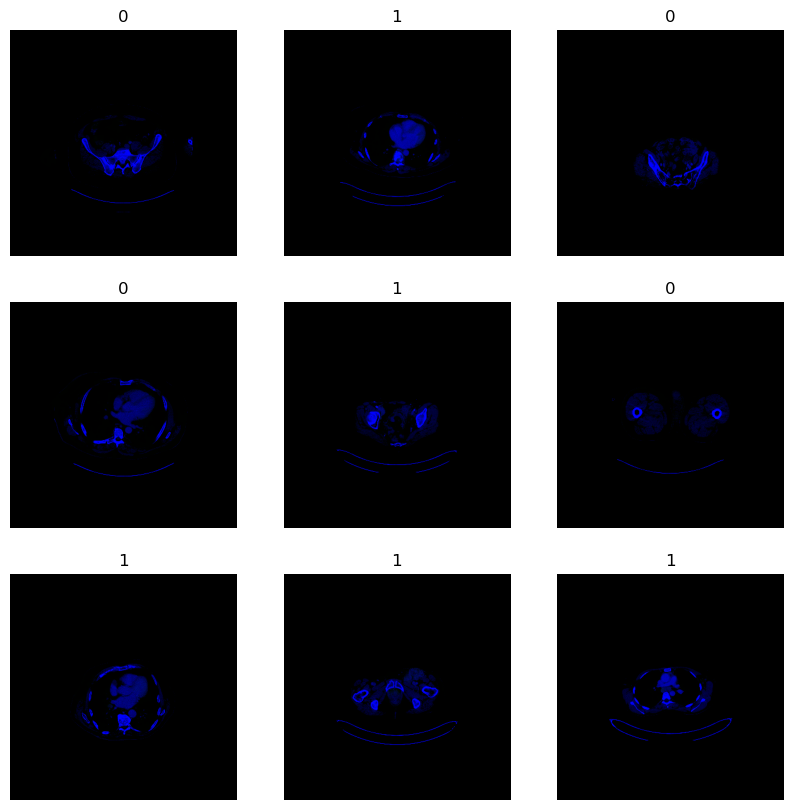

In [34]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [35]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 200 files belonging to 2 classes.


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [36]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [37]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal'),
#   tf.keras.layers.RandomRotation(0.2),
# ])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

In [38]:
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [39]:
preprocess_input = tf.keras.applications.densenet.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [40]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [41]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [42]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 12, 12, 1920)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [43]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [44]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1920)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [45]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [46]:
inputs = tf.keras.Input(shape=(DatasetConfig.HEIGHT, DatasetConfig.WIDTH, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [47]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 400, 400, 3)       0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 400, 400, 3)       0         
 da)                                                             
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 400, 400, 3)       0         
 bda)                                                            
                                                                 
 densenet201 (Functional)    (None, 12, 12, 1920)      18321984  
                                                           

The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [48]:
len(model.trainable_variables)

2

In [49]:
# !pip install pydot

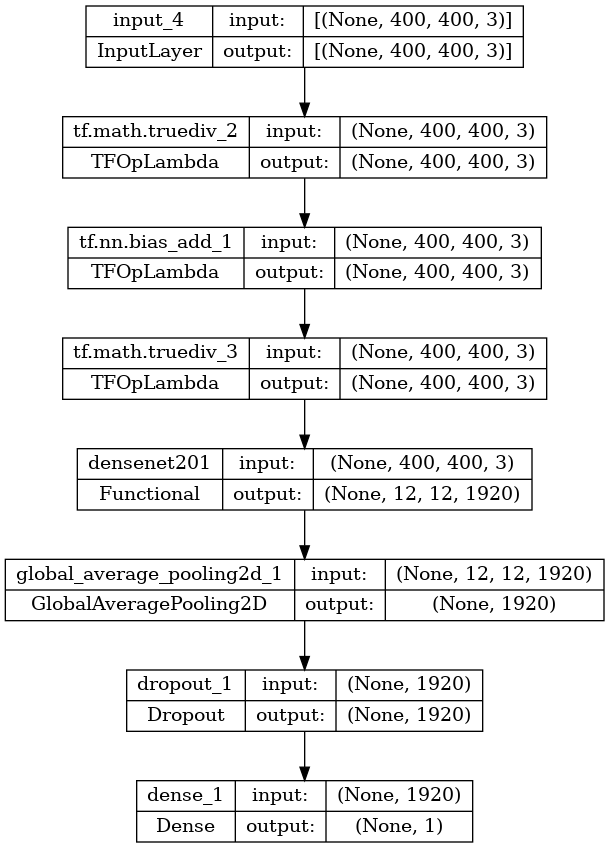

In [50]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile the model

Compile the model before training it. Since there are two classes and a sigmoid oputput, use the `BinaryAccuracy`.

In [51]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

### Train the model


In [52]:
initial_epochs = 200

loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 [==============================] - 2s 186ms/step - loss: 0.6775 - accuracy: 0.5875


In [53]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.68
initial accuracy: 0.59


### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [54]:
base_model.trainable = True

In [55]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 600

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  707


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [56]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              # optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [57]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 400, 400, 3)       0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 400, 400, 3)       0         
 da)                                                             
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 400, 400, 3)       0         
 bda)                                                            
                                                                 
 densenet201 (Functional)    (None, 12, 12, 1920)      18321984  
                                                           

In [58]:
len(model.trainable_variables)

94

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [59]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=fine_tune_epochs,
                         # initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 1/50
23/23 [==============================] - 31s 390ms/step - loss: 0.7105 - accuracy: 0.4855 - val_loss: 0.6716 - val_accuracy: 0.5500
Epoch 2/50
23/23 [==============================] - 3s 107ms/step - loss: 0.6921 - accuracy: 0.5448 - val_loss: 0.6624 - val_accuracy: 0.6750
Epoch 3/50
23/23 [==============================] - 3s 105ms/step - loss: 0.6871 - accuracy: 0.5407 - val_loss: 0.6546 - val_accuracy: 0.6750
Epoch 4/50
23/23 [==============================] - 2s 103ms/step - loss: 0.6748 - accuracy: 0.5655 - val_loss: 0.6470 - val_accuracy: 0.7000
Epoch 5/50
23/23 [==============================] - 2s 103ms/step - loss: 0.6648 - accuracy: 0.5931 - val_loss: 0.6411 - val_accuracy: 0.7000
Epoch 6/50
23/23 [==============================] - 2s 104ms/step - loss: 0.6575 - accuracy: 0.5931 - val_loss: 0.6347 - val_accuracy: 0.6750
Epoch 7/50
23/23 [==============================] - 2s 103ms/step - loss: 0.6532 - accuracy: 0.6193 - val_loss: 0.6309 - val_accuracy: 0.6625
Epoch

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8845 - loss: 0.2745

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8838 - loss: 0.2754

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8832 - loss: 0.2763

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8831 - loss: 0.2766

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8832 - loss: 0.2765

22/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8836 - loss: 0.2763

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8838 - loss: 0.2762

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8840 - loss: 0.2762

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8841 - loss: 0.2763

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8842 - loss: 0.2762

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8845 - loss: 0.2759

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8846 - loss: 0.2759

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8843 - loss: 0.2764

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8842 - loss: 0.2765

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8840 - loss: 0.2767

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8839 - loss: 0.2767

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8839 - loss: 0.2765

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8840 - loss: 0.2763

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8841 - loss: 0.2761

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8842 - loss: 0.2757

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8844 - loss: 0.2754

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8845 - loss: 0.2753

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8847 - loss: 0.2749

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8849 - loss: 0.2747

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8850 - loss: 0.2743

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8851 - loss: 0.2740

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8852 - loss: 0.2737

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8853 - loss: 0.2735

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8853 - loss: 0.2733 - val_accuracy: 0.9715 - val_loss: 0.0812


Epoch 13/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9062 - loss: 0.2526

 3/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9427 - loss: 0.2120

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9519 - loss: 0.1942

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9485 - loss: 0.1909

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9445 - loss: 0.1894

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9387 - loss: 0.1916

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9344 - loss: 0.1945

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9327 - loss: 0.1958

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9308 - loss: 0.1974

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9289 - loss: 0.1994

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9280 - loss: 0.2005

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9265 - loss: 0.2023

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9253 - loss: 0.2038

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9248 - loss: 0.2044

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9238 - loss: 0.2055

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9229 - loss: 0.2065

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9221 - loss: 0.2073

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9218 - loss: 0.2076

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9213 - loss: 0.2081

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9207 - loss: 0.2089

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9203 - loss: 0.2093

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9198 - loss: 0.2102

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9192 - loss: 0.2110

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9188 - loss: 0.2114

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9183 - loss: 0.2121

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9178 - loss: 0.2127

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9175 - loss: 0.2133

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9172 - loss: 0.2136

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9169 - loss: 0.2141

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9166 - loss: 0.2146

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9165 - loss: 0.2149

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9162 - loss: 0.2154

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9160 - loss: 0.2158

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9158 - loss: 0.2161

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9158 - loss: 0.2163

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9156 - loss: 0.2165

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9156 - loss: 0.2167 - val_accuracy: 0.9777 - val_loss: 0.0656


Epoch 14/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 1.0000 - loss: 0.0997

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9766 - loss: 0.1141

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9681 - loss: 0.1321

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9657 - loss: 0.1380

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9584 - loss: 0.1468

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9510 - loss: 0.1533

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9463 - loss: 0.1575

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9450 - loss: 0.1587

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9434 - loss: 0.1597

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9427 - loss: 0.1605

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9419 - loss: 0.1613

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9412 - loss: 0.1623

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9408 - loss: 0.1632

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9403 - loss: 0.1641

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9397 - loss: 0.1650

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9394 - loss: 0.1654

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9390 - loss: 0.1662

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9388 - loss: 0.1667

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9387 - loss: 0.1669

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9384 - loss: 0.1676

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9382 - loss: 0.1679

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9379 - loss: 0.1687

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9376 - loss: 0.1694

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9374 - loss: 0.1702

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9371 - loss: 0.1709

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9370 - loss: 0.1713

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9368 - loss: 0.1720

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9366 - loss: 0.1725

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9365 - loss: 0.1728

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9364 - loss: 0.1730

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9363 - loss: 0.1733

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9363 - loss: 0.1735

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9362 - loss: 0.1738

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9361 - loss: 0.1741

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9360 - loss: 0.1742

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9359 - loss: 0.1746

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9357 - loss: 0.1749

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9356 - loss: 0.1752

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9355 - loss: 0.1753 - val_accuracy: 0.9790 - val_loss: 0.0592


Epoch 15/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9688 - loss: 0.1888

 3/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9514 - loss: 0.1675

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9483 - loss: 0.1590

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9491 - loss: 0.1550

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9507 - loss: 0.1513

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9514 - loss: 0.1477

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9513 - loss: 0.1464

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9513 - loss: 0.1447

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9493 - loss: 0.1469

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9483 - loss: 0.1485

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9459 - loss: 0.1516

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9439 - loss: 0.1537

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9426 - loss: 0.1551

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9422 - loss: 0.1554

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9417 - loss: 0.1559

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9409 - loss: 0.1567

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9407 - loss: 0.1570

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9404 - loss: 0.1575

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9400 - loss: 0.1583

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9398 - loss: 0.1586

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9394 - loss: 0.1591

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9392 - loss: 0.1593

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9391 - loss: 0.1596

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9388 - loss: 0.1603

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9386 - loss: 0.1606

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9385 - loss: 0.1610

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9382 - loss: 0.1617

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9381 - loss: 0.1620

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9380 - loss: 0.1625

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9379 - loss: 0.1628

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9377 - loss: 0.1632

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9377 - loss: 0.1634

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9376 - loss: 0.1637

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9374 - loss: 0.1640

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9372 - loss: 0.1644

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9371 - loss: 0.1646

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9370 - loss: 0.1648

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9368 - loss: 0.1651

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9366 - loss: 0.1652

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9364 - loss: 0.1655

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9363 - loss: 0.1657

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9362 - loss: 0.1658 - val_accuracy: 0.9802 - val_loss: 0.0545


Epoch 16/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9688 - loss: 0.1078

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9609 - loss: 0.1243

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9434 - loss: 0.1378

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9384 - loss: 0.1418

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9374 - loss: 0.1417

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9364 - loss: 0.1415

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9357 - loss: 0.1426

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9350 - loss: 0.1451

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9350 - loss: 0.1461

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9354 - loss: 0.1464

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9359 - loss: 0.1468

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9364 - loss: 0.1466

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9369 - loss: 0.1462

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9379 - loss: 0.1454

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9381 - loss: 0.1454

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9381 - loss: 0.1455

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9385 - loss: 0.1453

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9385 - loss: 0.1454

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9387 - loss: 0.1455

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9387 - loss: 0.1455

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9387 - loss: 0.1455

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9387 - loss: 0.1455

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9387 - loss: 0.1455

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9388 - loss: 0.1454

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9388 - loss: 0.1455

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9388 - loss: 0.1455

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9388 - loss: 0.1455

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9390 - loss: 0.1454

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9391 - loss: 0.1454

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9391 - loss: 0.1454

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9392 - loss: 0.1454

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9392 - loss: 0.1454

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9392 - loss: 0.1455

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9392 - loss: 0.1456

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9391 - loss: 0.1456

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9391 - loss: 0.1457

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9391 - loss: 0.1458

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9392 - loss: 0.1458

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9392 - loss: 0.1458

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9392 - loss: 0.1458

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1457

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1457

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1457

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1458

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1458

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1459

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9393 - loss: 0.1459 - val_accuracy: 0.9851 - val_loss: 0.0497


Epoch 17/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.8750 - loss: 0.1786

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8906 - loss: 0.1586

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9028 - loss: 0.1517

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9095 - loss: 0.1488

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9159 - loss: 0.1470

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9202 - loss: 0.1443

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9222 - loss: 0.1436

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9234 - loss: 0.1432

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9247 - loss: 0.1426

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9257 - loss: 0.1418

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9276 - loss: 0.1412

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9296 - loss: 0.1404

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9307 - loss: 0.1397

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9318 - loss: 0.1391

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9330 - loss: 0.1384

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9341 - loss: 0.1377

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9359 - loss: 0.1364

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9366 - loss: 0.1360

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9373 - loss: 0.1357

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9379 - loss: 0.1353

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9385 - loss: 0.1350

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9391 - loss: 0.1346

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9396 - loss: 0.1342

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9406 - loss: 0.1337

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9410 - loss: 0.1336

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9413 - loss: 0.1335

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9420 - loss: 0.1333

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9423 - loss: 0.1332

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9426 - loss: 0.1330

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9429 - loss: 0.1329

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9431 - loss: 0.1327

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9434 - loss: 0.1325

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9436 - loss: 0.1324

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9440 - loss: 0.1323

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9442 - loss: 0.1322

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9444 - loss: 0.1322

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9446 - loss: 0.1321

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9448 - loss: 0.1321

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9449 - loss: 0.1321

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9451 - loss: 0.1321

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9452 - loss: 0.1322

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9454 - loss: 0.1322

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9455 - loss: 0.1322

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9456 - loss: 0.1323

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9459 - loss: 0.1323

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9460 - loss: 0.1324

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9461 - loss: 0.1324

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9463 - loss: 0.1324

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9465 - loss: 0.1324

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9465 - loss: 0.1324

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9467 - loss: 0.1325

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9468 - loss: 0.1325 - val_accuracy: 0.9814 - val_loss: 0.0517


Epoch 18/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9688 - loss: 0.1182

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9609 - loss: 0.1178

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9557 - loss: 0.1092

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9563 - loss: 0.1049

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9555 - loss: 0.1054

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9557 - loss: 0.1049

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9552 - loss: 0.1050

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9553 - loss: 0.1050

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9555 - loss: 0.1047

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9557 - loss: 0.1043

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9558 - loss: 0.1044

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9559 - loss: 0.1047

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9561 - loss: 0.1048

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9563 - loss: 0.1048

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9564 - loss: 0.1049

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9563 - loss: 0.1056

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9562 - loss: 0.1066

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9562 - loss: 0.1073

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9562 - loss: 0.1078

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9562 - loss: 0.1084

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9561 - loss: 0.1090

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9561 - loss: 0.1095

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9561 - loss: 0.1099

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9560 - loss: 0.1105

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9558 - loss: 0.1110

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9557 - loss: 0.1114

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9556 - loss: 0.1119

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9555 - loss: 0.1122

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9554 - loss: 0.1124

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9554 - loss: 0.1126

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9553 - loss: 0.1127

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9553 - loss: 0.1129

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9553 - loss: 0.1131

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9552 - loss: 0.1133

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9552 - loss: 0.1133

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9551 - loss: 0.1135

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9551 - loss: 0.1136

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9550 - loss: 0.1137

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1138

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1140

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9548 - loss: 0.1141

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9547 - loss: 0.1142

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9547 - loss: 0.1143

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9547 - loss: 0.1145

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9547 - loss: 0.1146

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9548 - loss: 0.1147

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9548 - loss: 0.1147

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1148

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1149

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1150

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1151

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9549 - loss: 0.1152

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9549 - loss: 0.1154 - val_accuracy: 0.9889 - val_loss: 0.0417


Epoch 19/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9062 - loss: 0.1450

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9219 - loss: 0.1286

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9340 - loss: 0.1224

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9368 - loss: 0.1214

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9407 - loss: 0.1175

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9437 - loss: 0.1139

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9460 - loss: 0.1114

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9502 - loss: 0.1066

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9521 - loss: 0.1043

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9533 - loss: 0.1032

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9540 - loss: 0.1027

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9545 - loss: 0.1025

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9551 - loss: 0.1026

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9556 - loss: 0.1027

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9562 - loss: 0.1027

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9564 - loss: 0.1031

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9567 - loss: 0.1033

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9569 - loss: 0.1035

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9571 - loss: 0.1037

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9571 - loss: 0.1043

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9571 - loss: 0.1048

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9571 - loss: 0.1053

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9572 - loss: 0.1056

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9573 - loss: 0.1058

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9573 - loss: 0.1059

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9575 - loss: 0.1060

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9576 - loss: 0.1060

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9577 - loss: 0.1060

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9578 - loss: 0.1061

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9579 - loss: 0.1061

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9580 - loss: 0.1061

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9581 - loss: 0.1061

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9581 - loss: 0.1062

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9581 - loss: 0.1063

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9581 - loss: 0.1065

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9581 - loss: 0.1067

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9580 - loss: 0.1068

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9579 - loss: 0.1070

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9579 - loss: 0.1072

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9578 - loss: 0.1075

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9576 - loss: 0.1078

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9575 - loss: 0.1081

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9575 - loss: 0.1084

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9574 - loss: 0.1086

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9574 - loss: 0.1087

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9574 - loss: 0.1089

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9574 - loss: 0.1090

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9573 - loss: 0.1091

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9573 - loss: 0.1092

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9573 - loss: 0.1093

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9573 - loss: 0.1094

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9573 - loss: 0.1095

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9572 - loss: 0.1096

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9572 - loss: 0.1097

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9572 - loss: 0.1098

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9572 - loss: 0.1098

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9571 - loss: 0.1099

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9571 - loss: 0.1101

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9570 - loss: 0.1103

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9569 - loss: 0.1105 - val_accuracy: 0.9851 - val_loss: 0.0428


Epoch 20/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9375 - loss: 0.1219

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9297 - loss: 0.1449

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9323 - loss: 0.1463

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9355 - loss: 0.1420

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9384 - loss: 0.1372

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9400 - loss: 0.1340

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9409 - loss: 0.1320

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9410 - loss: 0.1324

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9418 - loss: 0.1318

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9429 - loss: 0.1307

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9440 - loss: 0.1299

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9443 - loss: 0.1298

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9447 - loss: 0.1295

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9453 - loss: 0.1289

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9456 - loss: 0.1286

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9461 - loss: 0.1279

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9463 - loss: 0.1274

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9467 - loss: 0.1268

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9471 - loss: 0.1263

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9474 - loss: 0.1259

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9477 - loss: 0.1254

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9480 - loss: 0.1251

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9483 - loss: 0.1249

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9485 - loss: 0.1247

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9487 - loss: 0.1244

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9489 - loss: 0.1242

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9491 - loss: 0.1241

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9492 - loss: 0.1239

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9494 - loss: 0.1237

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9495 - loss: 0.1235

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9497 - loss: 0.1233

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9499 - loss: 0.1231

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9501 - loss: 0.1229

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9502 - loss: 0.1226

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9504 - loss: 0.1224

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9506 - loss: 0.1222

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9507 - loss: 0.1220

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9508 - loss: 0.1219

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9509 - loss: 0.1218

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9509 - loss: 0.1218

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9509 - loss: 0.1219

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9509 - loss: 0.1220

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9508 - loss: 0.1221

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9508 - loss: 0.1221

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9508 - loss: 0.1222

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9509 - loss: 0.1221

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9509 - loss: 0.1221

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9509 - loss: 0.1221

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9509 - loss: 0.1222

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9508 - loss: 0.1224

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9508 - loss: 0.1226

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9507 - loss: 0.1227

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9506 - loss: 0.1229

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9506 - loss: 0.1230

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9505 - loss: 0.1232

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9504 - loss: 0.1233

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9503 - loss: 0.1235

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9503 - loss: 0.1236

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9501 - loss: 0.1239

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9500 - loss: 0.1241

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9499 - loss: 0.1243 - val_accuracy: 0.9876 - val_loss: 0.0355


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

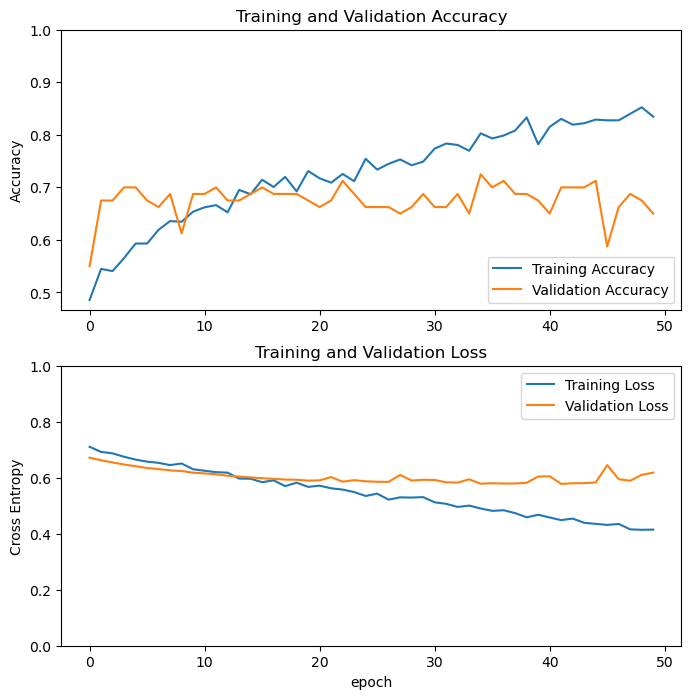

In [60]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [61]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

7/7 [==============================] - 1s 102ms/step - loss: 0.7070 - accuracy: 0.5650
Test accuracy : 0.5649999976158142


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1]
Labels:
 [0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0]


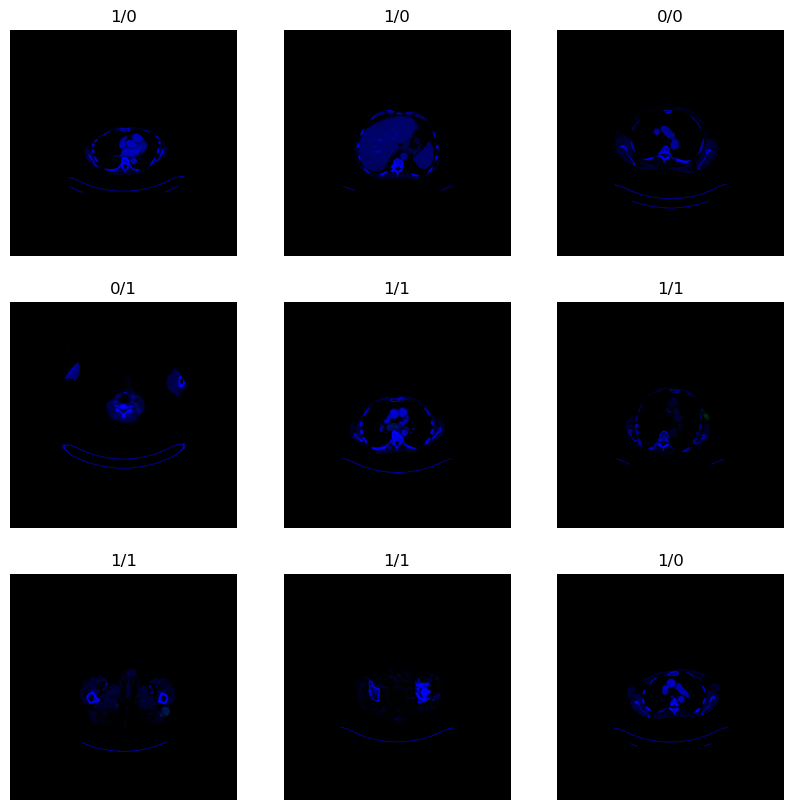

In [62]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f"{class_names[predictions[i]]}/{label_batch[i]}")
  plt.axis("off")